In [51]:
import pandas as pd
import re
import numpy as np

In [52]:
df = pd.read_json('./data/output.json', orient='records')
print(len(df))
df.head()

29472


,name,mana_cost,type_line,oracle_text,stats,img
0,+Two Mace,{1}{W},"[Artifact, Equipment]","[Equipped creature gets +2/+2., Equip {3} ({3}...",None,https://cards.scryfall.io/large/front/e/8/e882...
1,Aarakocra Sneak,{3}{U},"[Creature, Bird Rogue]","[Flying, When this creature enters, you take t...","[1, 4]",https://cards.scryfall.io/large/front/2/a/2a83...
2,"Aatchik, Emerald Radian",{3}{B}{B}{G},"[Legendary Creature, Insect Druid]","[When Aatchik enters, create a 1/1 green Insec...","[3, 3]",https://cards.scryfall.io/large/front/f/b/fbda...
3,Abaddon the Despoiler,{2}{U}{B}{R},"[Legendary Creature, Astartes Warrior]","[Trample, Mark of Chaos Ascendant — During you...","[5, 5]",https://cards.scryfall.io/large/front/c/9/c9f1...
4,Abandoned Campground,,[Land],[This land enters tapped unless a player has 1...,None,https://cards.scryfall.io/large/front/e/e/ee05...


<h1> Mana and Color </h1>
Calculate CMC and Color identity. Using domian knowledge these are more useful for similarity analysis compared to the granular mana costs

In [53]:
def sum_mana(mana_cost):
    total = 0
    parts = mana_cost.split('}')
    for part in parts:
        if part.startswith('{'):
            part = part[1:]
        if part.isdigit():
            total += int(part)
        elif part:
            total += 1
    return total

def find_mana_colour(row):
    mana_cost = row["mana_cost"]
    oracle = row["oracle_text"]
    colour_vector = np.zeros(5, dtype=int)
    mana_letters = {'W': 0, 'U': 1, 'B': 2, 'R': 3, 'G': 4}
    for letter in mana_cost:
        if letter in mana_letters:
            colour_vector[mana_letters[letter]] = 1
    valid = ""
    for line in oracle:
        open = False
        for char in line:
            if open:
                if char == "}":
                    open = False
                else:
                    valid += char
            elif char == "{":
                open = True
    for letter in valid:
        if letter in mana_letters:
            colour_vector[mana_letters[letter]] = 1
    return list(colour_vector)
        

df['cmc'] = df['mana_cost'].apply(sum_mana)
df['colours'] = df.apply(find_mana_colour, axis=1)
df = df.drop("mana_cost", axis=1)
df


,name,type_line,oracle_text,stats,img,cmc,colours
0,+Two Mace,"[Artifact, Equipment]","[Equipped creature gets +2/+2., Equip {3} ({3}...",None,https://cards.scryfall.io/large/front/e/8/e882...,2,"[1, 0, 0, 0, 0]"
1,Aarakocra Sneak,"[Creature, Bird Rogue]","[Flying, When this creature enters, you take t...","[1, 4]",https://cards.scryfall.io/large/front/2/a/2a83...,4,"[0, 1, 0, 0, 0]"
2,"Aatchik, Emerald Radian","[Legendary Creature, Insect Druid]","[When Aatchik enters, create a 1/1 green Insec...","[3, 3]",https://cards.scryfall.io/large/front/f/b/fbda...,6,"[0, 0, 1, 0, 1]"
3,Abaddon the Despoiler,"[Legendary Creature, Astartes Warrior]","[Trample, Mark of Chaos Ascendant — During you...","[5, 5]",https://cards.scryfall.io/large/front/c/9/c9f1...,5,"[0, 1, 1, 1, 0]"
4,Abandoned Campground,[Land],[This land enters tapped unless a player has 1...,None,https://cards.scryfall.io/large/front/e/e/ee05...,0,"[1, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree","[Legendary Creature, Orc Warrior]","[Mobilize 2 (Whenever this creature attacks, c...","[2, 4]",https://cards.scryfall.io/large/front/b/d/bd93...,3,"[1, 0, 1, 1, 0]"
29468,Zur's Weirding,[Enchantment],"[Players play with their hands revealed., If a...",None,https://cards.scryfall.io/large/front/7/4/7416...,4,"[0, 1, 0, 0, 0]"
29469,Zur the Enchanter,"[Legendary Creature, Human Wizard]","[Flying, Whenever Zur attacks, you may search ...","[1, 4]",https://cards.scryfall.io/large/front/5/6/561c...,4,"[1, 1, 1, 0, 0]"
29470,"Zurzoth, Chaos Rider","[Legendary Creature, Devil]",[Whenever an opponent draws their first card e...,"[2, 3]",https://cards.scryfall.io/large/front/c/6/c629...,3,"[0, 0, 0, 1, 0]"


<h1> Types </h1>
Wrangle Types, grouping supertype and type into one, then creating a subtype column. One hot vector encode the Types, Hash vector represent subtypes.

In [54]:
result = []
for type_line in df['type_line']:
    types = type_line[0].split(" ") if len(type_line) > 0 else []
    sub = type_line[1].split(" ") if len(type_line) > 1 else []
    result.append([types, sub])
    
df[['type', 'subtype']] = pd.DataFrame(result, index=df.index)
df = df.drop("type_line", axis=1)
df = df[df['type'].apply(lambda x: 'Stickers' not in x)]
df


,name,oracle_text,stats,img,cmc,colours,type,subtype
0,+Two Mace,"[Equipped creature gets +2/+2., Equip {3} ({3}...",None,https://cards.scryfall.io/large/front/e/8/e882...,2,"[1, 0, 0, 0, 0]",[Artifact],[Equipment]
1,Aarakocra Sneak,"[Flying, When this creature enters, you take t...","[1, 4]",https://cards.scryfall.io/large/front/2/a/2a83...,4,"[0, 1, 0, 0, 0]",[Creature],"[Bird, Rogue]"
2,"Aatchik, Emerald Radian","[When Aatchik enters, create a 1/1 green Insec...","[3, 3]",https://cards.scryfall.io/large/front/f/b/fbda...,6,"[0, 0, 1, 0, 1]","[Legendary, Creature]","[Insect, Druid]"
3,Abaddon the Despoiler,"[Trample, Mark of Chaos Ascendant — During you...","[5, 5]",https://cards.scryfall.io/large/front/c/9/c9f1...,5,"[0, 1, 1, 1, 0]","[Legendary, Creature]","[Astartes, Warrior]"
4,Abandoned Campground,[This land enters tapped unless a player has 1...,None,https://cards.scryfall.io/large/front/e/e/ee05...,0,"[1, 1, 0, 0, 0]",[Land],[]
...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree","[Mobilize 2 (Whenever this creature attacks, c...","[2, 4]",https://cards.scryfall.io/large/front/b/d/bd93...,3,"[1, 0, 1, 1, 0]","[Legendary, Creature]","[Orc, Warrior]"
29468,Zur's Weirding,"[Players play with their hands revealed., If a...",None,https://cards.scryfall.io/large/front/7/4/7416...,4,"[0, 1, 0, 0, 0]",[Enchantment],[]
29469,Zur the Enchanter,"[Flying, Whenever Zur attacks, you may search ...","[1, 4]",https://cards.scryfall.io/large/front/5/6/561c...,4,"[1, 1, 1, 0, 0]","[Legendary, Creature]","[Human, Wizard]"
29470,"Zurzoth, Chaos Rider",[Whenever an opponent draws their first card e...,"[2, 3]",https://cards.scryfall.io/large/front/c/6/c629...,3,"[0, 0, 0, 1, 0]","[Legendary, Creature]",[Devil]


In [55]:
types = set()
for example in df["type"]:
    for type in example:
        types.add(type)


noOfTypes = len(types)
print(noOfTypes,types)
types_indexes = {'Artifact': 0, 'Basic': 1, 'Battle': 2, 'Creature': 3, 'Enchantment': 4, "Instant":5, "Kindred":6, "Land":7, "Legendary":8, "Planeswalker":9, "Snow":10, "Sorcery":11, "World":12}

def vectorize_types(row):
    types = row["type"]
    type_vector = np.zeros(noOfTypes, dtype=int)
    for type in types:
        if type in types_indexes:
            type_vector[types_indexes[type]] = 1
    return type_vector

df["type"] = df.apply(vectorize_types, axis=1)

24 {'', 'Black', 'Color', 'Green\n', 'Creature', 'White', 'Land', 'Sorcery', 'Kindred', 'Snow', 'Planeswalker', 'Instant', 'Artifact', 'White\n', 'Legendary', 'Basic', 'Black\n', 'Red\n', 'Indicator:', 'Enchantment', 'Blue\n', 'World', 'Battle', 'and'}


In [56]:
from sklearn.feature_extraction import FeatureHasher

subtypes = set()
for example in df["subtype"]:
    for type in example:
        subtypes.add(type)

print(len(subtypes),subtypes)

print(list(df["subtype"]))
h = FeatureHasher(n_features=20, input_type="string")
f = h.fit_transform(list(df["subtype"]))
f = f.toarray()
res = [list(g) for g in f ]
print(res)
df["subtype"] = res
df


405 {'Ellywick', 'Beeble', 'Thalakos', 'Calix', 'Snail', 'Elf', 'Serra', 'Performer', 'Sivitri', 'Halfling', 'Pirate', 'Angel', 'Surrakar', 'Homarid', 'Spawn', 'Dovin', 'Peasant', 'Mole', 'Town', 'Elspeth', 'Devil', 'Nissa', 'Manticore', 'Werewolf', 'Basilisk', 'Knight', 'Tiefling', 'Freyalise', 'Toy', 'Skeleton', 'Saheeli', 'Koth', 'Mountain', 'Vampire', 'Alien', 'Djinn', 'Noble', 'Sable', 'Fractal', 'Lesson', 'Spellshaper', 'Ally', 'Custodes', 'Wall', 'Bahamut', 'Bear', 'Rogue', 'Sarkhan', 'Flagbearer', 'Assassin', 'Squid', 'Domri', 'Siren', 'Rebel', 'Sloth', 'Egg', 'Huatli', 'Fish', 'Lukka', 'Carrier', 'Snake', 'Mouse', 'Artificer', 'Licid', 'Venser', 'Elder', 'Zubera', 'Arcane', 'Nymph', 'Hag', 'Camel', 'Scout', 'Case', 'Dauthi', 'Tamiyo', 'Kithkin', 'Illusion', 'Swamp', 'Karn', 'Teyo', 'Kirin', 'Possum', 'Nephilim', 'Cyberman', 'Trilobite', 'Comet', 'Wrenn', 'Mordenkainen', 'Ninja', 'Tower', 'Background', 'Jeska', 'Wombat', 'Rigger', 'Elemental', 'Azra', 'Salamander', 'Echidna', '

,name,oracle_text,stats,img,cmc,colours,type,subtype
0,+Two Mace,"[Equipped creature gets +2/+2., Equip {3} ({3}...",None,https://cards.scryfall.io/large/front/e/8/e882...,2,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Aarakocra Sneak,"[Flying, When this creature enters, you take t...","[1, 4]",https://cards.scryfall.io/large/front/2/a/2a83...,4,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Aatchik, Emerald Radian","[When Aatchik enters, create a 1/1 green Insec...","[3, 3]",https://cards.scryfall.io/large/front/f/b/fbda...,6,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,..."
3,Abaddon the Despoiler,"[Trample, Mark of Chaos Ascendant — During you...","[5, 5]",https://cards.scryfall.io/large/front/c/9/c9f1...,5,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Abandoned Campground,[This land enters tapped unless a player has 1...,None,https://cards.scryfall.io/large/front/e/e/ee05...,0,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree","[Mobilize 2 (Whenever this creature attacks, c...","[2, 4]",https://cards.scryfall.io/large/front/b/d/bd93...,3,"[1, 0, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
29468,Zur's Weirding,"[Players play with their hands revealed., If a...",None,https://cards.scryfall.io/large/front/7/4/7416...,4,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29469,Zur the Enchanter,"[Flying, Whenever Zur attacks, you may search ...","[1, 4]",https://cards.scryfall.io/large/front/5/6/561c...,4,"[1, 1, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29470,"Zurzoth, Chaos Rider",[Whenever an opponent draws their first card e...,"[2, 3]",https://cards.scryfall.io/large/front/c/6/c629...,3,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<h1>Stats</h1>
Split Power and toughness, deal with any outliers such as "*/*", "-1/-1" or "*/1+*, etc. Also manage planewalkers and battles. Min-Max scale Stats and CMC

In [57]:
from sklearn.preprocessing import MinMaxScaler

result = []
for stat in df['stats']:
    if stat:
        ## Check if planes walker or battle
        if len(stat[0]) > 5:
            try:
                loyalty = int(stat[0][-1])
            except ValueError: 
                loyalty = 0
            result.append([0,0,loyalty])
        else: ##Is a creature
            power = stat[0]
            if "*" in power:
                power = 0
            else:
                power = abs(int(power))
            toughness = stat[1]
            if "*" in toughness:
                toughness = 0
            else:
                toughness = abs(int(toughness))
            result.append([power,toughness,0])
    else:
        result.append([0,0,0])
    
df[['power', 'toughness','loyalty']] = pd.DataFrame(result, index=df.index)
df = df.drop("stats", axis=1)



columns_to_scale = ['cmc', 'power', 'toughness', 'loyalty']
for col in columns_to_scale:
    print(col, df[col].min(), df[col].max())


scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

for col in columns_to_scale:
    print(col, df[col].min(), df[col].max())

df

cmc 0 16
power 0 20
toughness 0 20
loyalty 0 7
cmc 0.0 1.0
power 0.0 1.0
toughness 0.0 1.0
loyalty 0.0 1.0


,name,oracle_text,img,cmc,colours,type,subtype,power,toughness,loyalty
0,+Two Mace,"[Equipped creature gets +2/+2., Equip {3} ({3}...",https://cards.scryfall.io/large/front/e/8/e882...,0.1250,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0
1,Aarakocra Sneak,"[Flying, When this creature enters, you take t...",https://cards.scryfall.io/large/front/2/a/2a83...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0
2,"Aatchik, Emerald Radian","[When Aatchik enters, create a 1/1 green Insec...",https://cards.scryfall.io/large/front/f/b/fbda...,0.3750,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,...",0.15,0.15,0.0
3,Abaddon the Despoiler,"[Trample, Mark of Chaos Ascendant — During you...",https://cards.scryfall.io/large/front/c/9/c9f1...,0.3125,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.25,0.25,0.0
4,Abandoned Campground,[This land enters tapped unless a player has 1...,https://cards.scryfall.io/large/front/e/e/ee05...,0.0000,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree","[Mobilize 2 (Whenever this creature attacks, c...",https://cards.scryfall.io/large/front/b/d/bd93...,0.1875,"[1, 0, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.10,0.20,0.0
29468,Zur's Weirding,"[Players play with their hands revealed., If a...",https://cards.scryfall.io/large/front/7/4/7416...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0
29469,Zur the Enchanter,"[Flying, Whenever Zur attacks, you may search ...",https://cards.scryfall.io/large/front/5/6/561c...,0.2500,"[1, 1, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0
29470,"Zurzoth, Chaos Rider",[Whenever an opponent draws their first card e...,https://cards.scryfall.io/large/front/c/6/c629...,0.1875,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.10,0.15,0.0


<h1>Oracle text</h1>
Basic Text preparation, replacing card name in text with place holder, removing any special characters and flattening to a single string.

In [58]:
def pad(input:str):
    return " " + input + " "

def process_oracle(row):
    oracle_text = row["oracle_text"]
    text = ""
    for part in oracle_text: ## Combine Strings of oracle text
        if "—" in part:  ##Removes Flavour Text
            part = part.split("—",1)[1]
        text += pad(part) 
    ##Format text
    text = text.lower() ## convert to lower
    text = text.replace(":",pad("then")) ## : goes to then - uncover game logic
    text = re.sub( r"[^a-zA-Z0-9 +\-,'{}'/]", ' ', text) ## remove unecessary special characters
    text = text.replace("}", "} ") ## Seperates Mana symbols
    text = re.sub(r'\s+', ' ', text).strip() ## Remove excess whitespace (converts all multiple white space to single) 
    return text


df["text"] = df.apply(process_oracle, axis=1)
df = df.drop("oracle_text", axis=1)
df

,name,img,cmc,colours,type,subtype,power,toughness,loyalty,text
0,+Two Mace,https://cards.scryfall.io/large/front/e/8/e882...,0.1250,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,equipped creature gets +2/+2 equip {3} {3} the...
1,Aarakocra Sneak,https://cards.scryfall.io/large/front/2/a/2a83...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying when this creature enters, you take the..."
2,"Aatchik, Emerald Radian",https://cards.scryfall.io/large/front/f/b/fbda...,0.3750,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,...",0.15,0.15,0.0,"when aatchik enters, create a 1/1 green insect..."
3,Abaddon the Despoiler,https://cards.scryfall.io/large/front/c/9/c9f1...,0.3125,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.25,0.25,0.0,"trample during your turn, spells you cast from..."
4,Abandoned Campground,https://cards.scryfall.io/large/front/e/e/ee05...,0.0000,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,this land enters tapped unless a player has 13...
...,...,...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree",https://cards.scryfall.io/large/front/b/d/bd93...,0.1875,"[1, 0, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.10,0.20,0.0,"mobilize 2 whenever this creature attacks, cre..."
29468,Zur's Weirding,https://cards.scryfall.io/large/front/7/4/7416...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,players play with their hands revealed if a pl...
29469,Zur the Enchanter,https://cards.scryfall.io/large/front/5/6/561c...,0.2500,"[1, 1, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying whenever zur attacks, you may search yo..."
29470,"Zurzoth, Chaos Rider",https://cards.scryfall.io/large/front/c/6/c629...,0.1875,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.10,0.15,0.0,whenever an opponent draws their first card ea...


In [59]:
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords, words

ps = PorterStemmer()
stops = set(stopwords.words('english'))

placeholder = "CARDNAME"

def tokenize_oracle(row):
    ## Collect needed info
    card_name = row["name"].lower().strip()
    text = row["text"].strip()

    ## Get Nicknames
    nickname_no_desc = card_name.split(",")[0].strip() if "," in card_name else None ##Catches "Name, YYYY"
    if nickname_no_desc in stops:
        nickname_no_desc = None
    nickname_no_desc_s = nickname_no_desc + "'s" if nickname_no_desc else None
    nickname_no_the = card_name.split(" ")[0].strip() if " " in card_name else None ## Catches "Name the YYYYY"
    if nickname_no_the in stops:
        nickname_no_the = None
    nickname_no_the_s = nickname_no_the + "'s" if nickname_no_the else None


    ## Check full card name mention
    if card_name in text:
        text = text.replace(card_name,placeholder)

    ## Split into tokens

    text = text.replace(",", "")
    text = text.split(" ")

    ## Collect Valid tokens
    res = ["<sos>"]
    for word in text:
        if word == nickname_no_desc or word == nickname_no_desc_s or word == nickname_no_the or word == nickname_no_the_s or word == placeholder:
                res.append(placeholder)
        else:
            res.append(ps.stem(word))
    res.append("<eos>")
    return res


df["tokens"] = df.apply(tokenize_oracle, axis=1)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benwm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Benwm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,name,img,cmc,colours,type,subtype,power,toughness,loyalty,text,tokens
0,+Two Mace,https://cards.scryfall.io/large/front/e/8/e882...,0.1250,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,equipped creature gets +2/+2 equip {3} {3} the...,"[<sos>, equip, creatur, get, +2/+2, equip, {3}..."
1,Aarakocra Sneak,https://cards.scryfall.io/large/front/2/a/2a83...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying when this creature enters, you take the...","[<sos>, fli, when, thi, creatur, enter, you, t..."
2,"Aatchik, Emerald Radian",https://cards.scryfall.io/large/front/f/b/fbda...,0.3750,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,...",0.15,0.15,0.0,"when aatchik enters, create a 1/1 green insect...","[<sos>, when, CARDNAME, enter, creat, a, 1/1, ..."
3,Abaddon the Despoiler,https://cards.scryfall.io/large/front/c/9/c9f1...,0.3125,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.25,0.25,0.0,"trample during your turn, spells you cast from...","[<sos>, trampl, dure, your, turn, spell, you, ..."
4,Abandoned Campground,https://cards.scryfall.io/large/front/e/e/ee05...,0.0000,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,this land enters tapped unless a player has 13...,"[<sos>, thi, land, enter, tap, unless, a, play..."
...,...,...,...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree",https://cards.scryfall.io/large/front/b/d/bd93...,0.1875,"[1, 0, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.10,0.20,0.0,"mobilize 2 whenever this creature attacks, cre...","[<sos>, mobil, 2, whenev, thi, creatur, attack..."
29468,Zur's Weirding,https://cards.scryfall.io/large/front/7/4/7416...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,players play with their hands revealed if a pl...,"[<sos>, player, play, with, their, hand, revea..."
29469,Zur the Enchanter,https://cards.scryfall.io/large/front/5/6/561c...,0.2500,"[1, 1, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying whenever zur attacks, you may search yo...","[<sos>, fli, whenev, CARDNAME, attack, you, ma..."
29470,"Zurzoth, Chaos Rider",https://cards.scryfall.io/large/front/c/6/c629...,0.1875,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.10,0.15,0.0,whenever an opponent draws their first card ea...,"[<sos>, whenev, an, oppon, draw, their, first,..."


<h1> Create Custom Word2Vec with Gensim</h1>


In [60]:
sentences = [text for text in df["tokens"]]
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from tqdm import tqdm

In [61]:
path = get_tmpfile("./models/word2vec.model")

# Configure and train the model
model = Word2Vec(
    sentences=tqdm(sentences),  # Show progress bar during training
    vector_size=100,            # Dimensionality of word vectors
    window=5,                   # Maximum distance between target and context words
    min_count=0,                # Ignore words with fewer occurrences
    workers=4,                  # Number of CPU cores to use
    sg=1,                       # Training algorithm: 1 for skip-gram, 0 for CBOW
    epochs=5                    # Number of iterations over the corpus
)

# Save the model for later use
model.save("./models/word2vec.model")

100%|██████████| 29424/29424 [00:00<00:00, 392303.54it/s]


In [62]:
model = Word2Vec.load("./models/word2vec.model")

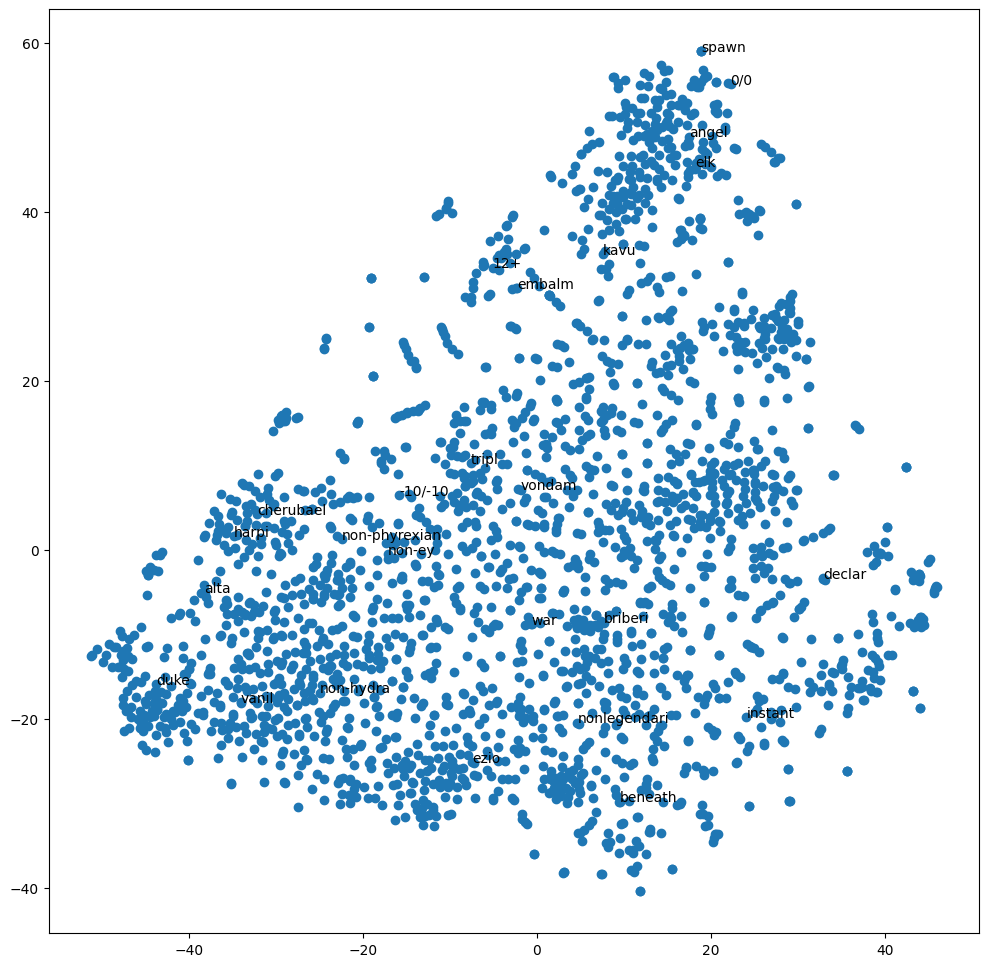

In [63]:
from sklearn.manifold import TSNE                  
import numpy as np                                  


def reduce_dimensions(model):
    num_dimensions = 2 
    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings
    tsne = TSNE(n_components=num_dimensions, random_state=0) # reduce using t-SNE
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_with_matplotlib(x_vals, y_vals, labels)

In [64]:
model.wv['CARDNAME']

array([-1.63546931e-02, -1.11092508e-01, -2.39135295e-01, -1.13633670e-01,
       -2.85235882e-01, -2.24571943e-01,  2.19477445e-01,  1.02989249e-01,
       -4.49594222e-02, -2.59755552e-01, -1.29329935e-01, -2.85822272e-01,
        3.19104314e-01, -2.15095710e-02, -1.21693686e-01, -1.73020884e-01,
        3.89309108e-01, -2.80665040e-01, -1.91165600e-02, -2.69158602e-01,
        6.76684380e-01, -1.01124413e-01,  5.48573494e-01,  3.13541204e-01,
       -2.86757469e-01,  2.03916430e-02, -1.34853631e-01,  7.54195973e-02,
       -2.66699195e-01,  2.47549210e-02,  3.12764794e-01,  9.16219652e-02,
        3.94944400e-01, -1.87331606e-02,  6.06204197e-02, -3.82408835e-02,
        1.24597631e-01, -3.86669338e-01, -4.21209097e-01, -2.51298070e-01,
        3.29496115e-02, -4.16095227e-01,  1.89236283e-01,  1.21706165e-01,
        1.94864869e-02, -5.00890687e-02, -2.16957983e-02, -1.14088684e-01,
       -1.70205519e-01,  1.92607507e-01,  2.51073688e-01, -2.74553299e-01,
       -1.81677029e-01,  

In [65]:
vocab = {}
for index,word in enumerate(model.wv.key_to_index):
    vocab[word] = index
    
print(vocab)
print(len(vocab))


{'creatur': 0, '<sos>': 1, '<eos>': 2, 'thi': 3, 'you': 4, 'a': 5, 'it': 6, 'of': 7, 'card': 8, 'the': 9, 'then': 10, 'your': 11, 'to': 12, 'target': 13, 'control': 14, 'turn': 15, 'or': 16, 'and': 17, 'that': 18, 'counter': 19, 'if': 20, 'put': 21, 'on': 22, 'enter': 23, 'may': 24, 'end': 25, 'with': 26, 'each': 27, 'whenev': 28, 'cast': 29, 'when': 30, 'spell': 31, 's': 32, 'as': 33, 'from': 34, 'until': 35, 'damag': 36, 'player': 37, '': 38, 'an': 39, 'get': 40, '{t}': 41, 'for': 42, 'enchant': 43, 'token': 44, '+1/+1': 45, 'artifact': 46, 'gain': 47, 'graveyard': 48, 't': 49, 'fli': 50, 'deal': 51, 'CARDNAME': 52, 'hand': 53, 'exil': 54, 'sacrific': 55, 'at': 56, 'draw': 57, 'can': 58, 'librari': 59, 'land': 60, 'attack': 61, 'oppon': 62, 'life': 63, 'mana': 64, 'creat': 65, 'ani': 66, 'is': 67, '{2}': 68, 'cost': 69, '{1}': 70, 'block': 71, 'two': 72, 'battlefield': 73, 'tap': 74, 'pay': 75, 'begin': 76, 'be': 77, 'one': 78, 'x': 79, 'in': 80, 'perman': 81, 'add': 82, '1': 83, 're

In [66]:
model.wv[vocab["thi"]] == model.wv["thi"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [67]:
def enumerate_tokens(row):
    tokens = row["tokens"]
    res = []
    for token in tokens:
        res.append(vocab[token])
    return res

df["tokens"] = df.apply(enumerate_tokens, axis=1)
df


,name,img,cmc,colours,type,subtype,power,toughness,loyalty,text,tokens
0,+Two Mace,https://cards.scryfall.io/large/front/e/8/e882...,0.1250,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,equipped creature gets +2/+2 equip {3} {3} the...,"[1, 96, 0, 40, 186, 96, 116, 116, 10, 169, 12,..."
1,Aarakocra Sneak,https://cards.scryfall.io/large/front/2/a/2a83...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying when this creature enters, you take the...","[1, 50, 30, 3, 0, 23, 4, 428, 9, 629, 2]"
2,"Aatchik, Emerald Radian",https://cards.scryfall.io/large/front/f/b/fbda...,0.3750,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,...",0.15,0.15,0.0,"when aatchik enters, create a 1/1 green insect...","[1, 30, 52, 23, 65, 5, 131, 162, 430, 0, 44, 4..."
3,Abaddon the Despoiler,https://cards.scryfall.io/large/front/c/9/c9f1...,0.3125,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.25,0.25,0.0,"trample during your turn, spells you cast from...","[1, 128, 152, 11, 15, 31, 4, 29, 34, 11, 53, 2..."
4,Abandoned Campground,https://cards.scryfall.io/large/front/e/e/ee05...,0.0000,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,this land enters tapped unless a player has 13...,"[1, 3, 60, 23, 74, 159, 5, 37, 88, 677, 16, 12..."
...,...,...,...,...,...,...,...,...,...,...,...
29467,"Zurgo, Thunder's Decree",https://cards.scryfall.io/large/front/b/d/bd93...,0.1875,"[1, 0, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.10,0.20,0.0,"mobilize 2 whenever this creature attacks, cre...","[1, 848, 90, 28, 3, 0, 61, 65, 72, 74, 17, 61,..."
29468,Zur's Weirding,https://cards.scryfall.io/large/front/7/4/7416...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,players play with their hands revealed if a pl...,"[1, 37, 207, 26, 93, 53, 111, 20, 5, 37, 138, ..."
29469,Zur the Enchanter,https://cards.scryfall.io/large/front/5/6/561c...,0.2500,"[1, 1, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"flying whenever zur attacks, you may search yo...","[1, 50, 28, 52, 61, 4, 24, 143, 11, 59, 42, 39..."
29470,"Zurzoth, Chaos Rider",https://cards.scryfall.io/large/front/c/6/c629...,0.1875,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.10,0.15,0.0,whenever an opponent draws their first card ea...,"[1, 28, 39, 62, 57, 93, 141, 8, 27, 15, 20, 6,..."


In [68]:
df = df.drop("text", axis=1)

<h1> Image Processing </h1>

Exchange large images for normal scryfall images, better for flask interface

In [69]:
def update_img(row):
    img_src = row["img"]
    return img_src.replace("large","normal",1)


df["img"] = df.apply(update_img,axis=1)
df.head()

,name,img,cmc,colours,type,subtype,power,toughness,loyalty,tokens
0,+Two Mace,https://cards.scryfall.io/normal/front/e/8/e88...,0.1250,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,"[1, 96, 0, 40, 186, 96, 116, 116, 10, 169, 12,..."
1,Aarakocra Sneak,https://cards.scryfall.io/normal/front/2/a/2a8...,0.2500,"[0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.05,0.20,0.0,"[1, 50, 30, 3, 0, 23, 4, 428, 9, 629, 2]"
2,"Aatchik, Emerald Radian",https://cards.scryfall.io/normal/front/f/b/fbd...,0.3750,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0,...",0.15,0.15,0.0,"[1, 30, 52, 23, 65, 5, 131, 162, 430, 0, 44, 4..."
3,Abaddon the Despoiler,https://cards.scryfall.io/normal/front/c/9/c9f...,0.3125,"[0, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.25,0.25,0.0,"[1, 128, 152, 11, 15, 31, 4, 29, 34, 11, 53, 2..."
4,Abandoned Campground,https://cards.scryfall.io/normal/front/e/e/ee0...,0.0000,"[1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00,0.00,0.0,"[1, 3, 60, 23, 74, 159, 5, 37, 88, 677, 16, 12..."


In [70]:
df.loc[0]["img"]

'https://cards.scryfall.io/normal/front/e/8/e882c9f9-bf30-46b6-bedc-379d2c80e5cb.jpg?1627701221'

In [71]:
df.to_json('./data/data.json', orient='records', indent=4)